<a href="https://colab.research.google.com/github/jerpint/jerpint.github.io/blob/dev/Feature_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Feature Visualization

In this notebook, we will explore how to implement feature visualization. A lot of neat posts show some really cool examples of what can be done with feature viz, and I was interested in how hard it might be (or not) to reproduce some results.



## Brief Intro

At its core, feature visualization is the reverse of training a neural network - instead of modifiying the weights of a network to make a prediction, we adjust the input of a pretrained network to make its activations fire maximally.

The idea is that if we can find how to optimize what triggers a layer/channel/neuron inside a neural network, we can gain insight into what the network has learned.

We can use the principles of backpropagation to optimize our network. If you are familiar with implementing training loops in pytorch, this will be pretty self explanatory with code.

It turns out that a lot of tricks end up being used to make the visualizations look good in practice. We will start with a vanilla implementation and add a few tricks to get better visualizations. I have to admit it is difficult to reproduce some of the figures without them, but with enough imagination you start seeing a lot of the magic early on.

# Implementations

We will begin with the simplest implementation we can think of. We will also be using a simple network, simple in the sense that the architecture flow is essentially linear. This makes extracting intermediate features a lot easier.

We will get started with a VGG-style model, specifically VGG-19.

### Helper functions (run this first!)

In [45]:
# helper functions for initializing targets and displaying results
import numpy as np
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm

def init_target(width, height, device, batch_size=1):
  '''Initialize the target we will optimize. 
  
  Here we use uniform noise in the range -1, 1.
  '''
  target = np.random.uniform(low=-1, high=1, size=(batch_size, 3, height, width))
  target = torch.tensor(target, dtype=torch.float, requires_grad=True, device=device)
  return target

def deprocess_image(x):
  '''Transform a matrix so that it is in the [0, 255] range.'''
  x = (255*(x - np.min(x))/np.ptp(x)).astype(int)  
  return x

def display_targets(target, caption=None, save=False, show=True):
  '''Utility function to display the target.
  
  Can also be used to save figures to disk (useful for making animated gifs)
  '''
  targets_final = np.moveaxis(target[:, :, :, :].detach().cpu().numpy(), 1, 3)
  final_images = [deprocess_image(final_target) for final_target in targets_final]
  fig, axs = plt.subplots(1, batch_size, figsize=(5, 5))
  if caption:
    fig.suptitle(caption)
  
  if not show: # avoid displaying using imshow when saving to disk
    plt.ioff()

  for idx, image in enumerate(final_images):
    ## If batch size is 1, we have a single image, otherwise we need 
    ## to plot multiple images
    try:  # multiple images
      axs[idx].imshow(image)
      axs[idx].set_xticks([])
      axs[idx].set_yticks([])
    except:  #  single image
      axs.imshow(image)
      axs.set_xticks([])
      axs.set_yticks([])
  if save:  # save to disk
    plt.savefig(caption + '.png')
  if not show:
    plt.close()
  else:
    plt.show()


device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda:0


## VGG19

Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


100%|██████████| 2000/2000 [00:44<00:00, 44.83it/s]


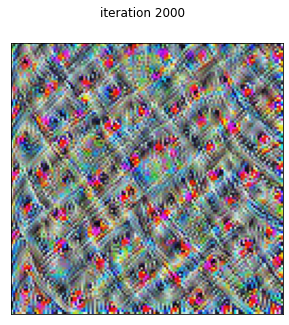

In [46]:
class CustomVgg19(torch.nn.Module):
            def __init__(self, stop_layer, device, pretrained=True):
                '''Utility class to define our model.

                We can "slice" the network at any layer, using the stop_layer
                argument to define that layer. The model will return the
                feature map at that sliced layer. We use by default a pretrained  
                network.
                '''
                super(CustomVgg19, self).__init__()
                vgg19 = models.vgg19(pretrained=pretrained)
                vgg19 = vgg19.to(device)
                self.features = torch.nn.Sequential(
                    *list(vgg19.features.children())[:stop_layer]
                )
            def forward(self, x):
                return self.features(x)


lr = 0.05
wd = 1e-6
n_iters = 2000
batch_size = 1
stop_layer = 20
target = init_target(width=128, height=128, device=device) # normalized uniform noise
model = CustomVgg19(stop_layer=stop_layer, pretrained=True, device=device)
optimizer = torch.optim.Adam([target], lr=lr, weight_decay=wd)
for n_iter in tqdm(range(1, n_iters + 1)):
    optimizer.zero_grad()
    out = model.forward(target)
    loss = -torch.mean(out[:, 42, :, :])
    loss.backward()
    optimizer.step()

display_targets(target, caption=f'iteration {n_iter:04}', save=False, show=True)

Pretty cool so far. So let's look at what's happening: first of all, look at what we are optimizing for: 


`loss = -torch.mean(out[:, 42, :, :])`

Remember that our output has dimensions [batch, channel, width, height] - so in this case, we are optimizing the 42nd channel of the 20th layer of VGG19 (in this sense, ReLUs, "count" as layers as far as this implementation is concerned). You can see the model definition in the next cell.

The goal is to optimize the target to maximally activate the layer we have targeted. In this case, the output is already at the stop layer, so we optimize across every batch (in this example, batch size is 1), pick a channel (42), use all their neurons, and average them all together.

The minus is because neural networks are great at MINIMIZING. So by MINIMIZING the NEGATIVE, we are MAXIMIZING the output of the channel.

You can play around with slicing the output by channel, by neuron, etc.

Now let's inspect the model we are currently optimizing:

In [47]:
display(model)

CustomVgg19(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 

As you can see, we are stopping after the 9th convolutional layer. You can obviously pick where you stop, etc.

However you will notice in some cases it might be hard to get some proper signal. We will explore in the next cells some ideas that can help up smooth the optimization process.

## Add some regularization tricks

We will add a few tricks to make our output a bit "smoother": we will start with a small image, and increase it every few iterations. We will also simultaneously add some noise to our image and use some gaussian blurring to smooth out the signal. Let's see how that works out in our example:

In [48]:
import numpy as np
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.signal import gaussian

def init_blur(k=3):
  '''
  Setup a gaussian blur on images using convolutions
  '''
  conv_weights = np.zeros((3, 3, k, k))
  gauss1d = gaussian(k, std=0.6)
  gauss2d = np.outer(gauss1d, gauss1d) 
  gauss2d = gauss2d / np.sqrt(sum(gauss2d))
  conv_weights[0, 0, :, :] = gauss2d
  conv_weights[1, 1, :, :] = gauss2d
  conv_weights[2, 2, :, :] = gauss2d
  # blur = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=k, bias=False, padding=k-2)
  blur = torch.nn.Conv2d(in_channels=3, out_channels=3, kernel_size=k, bias=False, padding=k-2)
  with torch.no_grad():
    blur.weight = torch.nn.parameter.Parameter(torch.tensor(conv_weights, dtype=torch.float), requires_grad=False)
  blur = blur.to(device)
  return blur

def enlarge(target, scale_factor=1.1):
  return torch.nn.functional.interpolate(target, scale_factor=scale_factor)


def add_noise(target, noise_factor):
  noise = np.random.random(target.shape) - 0.5
  noise = torch.tensor(noise, dtype=torch.float, device=device)
  target = target.detach().clone()
  target += noise_factor*noise
  target -= target.mean()
  target /= target.std()
  target = torch.tensor(target, dtype=torch.float, requires_grad=True, device=device)
  return target

  2%|▏         | 23/1499 [00:00<00:12, 115.95it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTenso

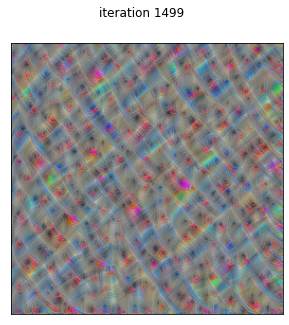

In [49]:
blur = init_blur()

sf = 1.1
nf = 1
lr = 0.05
wd = 1e-6
n_iters = (150 * 10) - 1
batch_size = 1
stop_layer = 20

# target = init_target(width=100, height=100, device=device) # (3, 224, 224) normalized random noise
target = init_target(width=64, height=64, device=device) # (3, 224, 224) normalized random noise
model = CustomVgg19(stop_layer=stop_layer, pretrained=True, device=device)
optimizer = torch.optim.Adam([target], lr=lr, weight_decay=wd)
for n_iter in tqdm(range(1, n_iters + 1)):
    optimizer.zero_grad()

    out = model.forward(target)
    loss = -torch.mean(out[:, 42, :, :])
    loss.backward()
    optimizer.step()

    if n_iter % 30 == 0:
      display_targets(target, caption=f'iteration {n_iter:04}', save=True, show=False)
      nf = np.random.randint(0, 3)
      target = blur(add_noise(enlarge(target, scale_factor=sf), noise_factor=nf))
      target = torch.tensor(target, dtype=torch.float, requires_grad=True, device=device)
      optimizer = torch.optim.Adam([target], lr=lr, weight_decay=wd) # reset optimizer

    if target.shape[-1] > 256: # Max image dimension
      sf = 1.0

display_targets(target, caption=f'iteration {n_iter:04}', save=False, show=True)

The tricks seem to have helped - our image looks smoother and cleaner.

## Let's go DEEPER

OK - now that we have a working prototype let's go explore some deeper layers. We will go to the last conv. layer of the VGG19 model. I'll also be tweaking around with a bunch of parameters - feel free to explore on your own!

  2%|▏         | 47/2499 [00:00<00:42, 57.09it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3503: UserWarning: The default behavior for interpolate/upsample with float scale_factor changed in 1.6.0 to align with other frameworks/libraries, and now uses scale_factor directly, instead of relying on the computed output size. If you wish to restore the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  "The default behavior for interpolate/upsample with float scale_factor changed "
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:29: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor

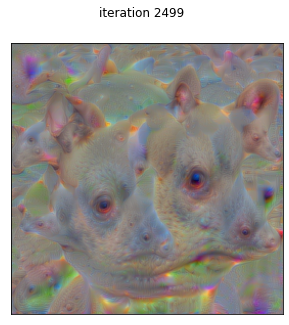

In [50]:
!rm -r *.png  # remove any existing images, they will interfere with the animation.

blur = init_blur(k=3)
sf = 1.05
nf = 1
lr = 0.2
wd = 1e-6
n_iters = (50 * 50) - 1
batch_size = 1
stop_layer = 33
channel = 301

target = init_target(width=32, height=32, device=device) # (3, 224, 224) normalized random noise
model = CustomVgg19(stop_layer=stop_layer, pretrained=True, device=device)
optimizer = torch.optim.Adam([target], lr=lr, weight_decay=wd)
for n_iter in tqdm(range(1, n_iters + 1)):
    optimizer.zero_grad()

    out = model.forward(target)
    loss = -torch.mean(out[:, channel, :, :])
    # loss = -torch.mean(out[:, 300, :, :])
    loss.backward()
    optimizer.step()

    if n_iter % 50 == 0:
      display_targets(target, caption=f'iteration {n_iter:04}', save=True, show=False)
      nf = np.random.randint(0, 3)
      target = blur(add_noise(enlarge(target, scale_factor=sf), noise_factor=nf))
      target = torch.tensor(target, dtype=torch.float, requires_grad=True, device=device)
      
      if lr > 0.01:
        lr *= 0.97
      optimizer = torch.optim.Adam([target], lr=lr, weight_decay=wd) # reset optimizer

    if n_iter == 1000: # do some more accentuated changes
      sf = 1.1
      lr *= 0.5
      wd *= 10
      target = blur(enlarge(target, scale_factor=sf))
      target = torch.tensor(target, dtype=torch.float, requires_grad=True, device=device)
      optimizer = torch.optim.Adam([target], lr=lr, weight_decay=wd) # reset optimizer
      sf = 1.05

display_targets(target, caption=f'iteration {n_iter:04}', save=False, show=True)

Cool! Now wouldn't it be cool to see the progress of our network reversing itself? Yes - it would be ;) Run the next cell to create a gif of the whole process.

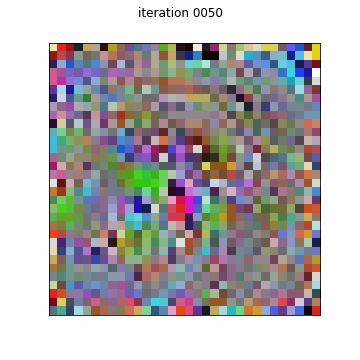

In [51]:
# Code to make an animation of all intermediate steps
from IPython.display import Image as IPyImage
from PIL import Image
import glob
 
# Create the frames
frames = []
imgs = glob.glob("*.png")
imgs = sorted(imgs)

for i in imgs:
    frame = Image.open(i)
    frame.resize((10, 5))
    frames.append(frame)
 
# Save into a GIF file that loops forever
frames[0].save('png_to_gif.gif', format='GIF',
               append_images=frames[1:],
               save_all=True,
               duration=70, loop=0)
               
# show Gif inline
IPyImage(open('png_to_gif.gif','rb').read())